In [5]:
# ============================================
#  Лаба 10. Метод главных компонент (PCA)
#  Датасет: ISOLET (617 признаков)
# ============================================

# 1. Импорт библиотек
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.datasets import fetch_openml
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix


In [6]:
# 2. Загрузка ISOLET с OpenML
isolet = fetch_openml("isolet", version=1, as_frame=True)
X = isolet.data      # признаки (DataFrame 7797 x 617)
y = isolet.target    # метки классов (серия из букв 'A'...'Z')

print(f"Размер X: {X.shape}, классы: {sorted(y.unique())[:5]} … {sorted(y.unique())[-5:]}")


Размер X: (7797, 617), классы: ['1', '10', '11', '12', '13'] … ['5', '6', '7', '8', '9']


In [8]:
# 3. Трейн-тест-сплит (70/30)
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.30, random_state=42, stratify=y)

# 4. Масштабирование признаков (StandardScaler обязателен перед PCA / LogisticRegression!)
scaler = StandardScaler()
X_train_std = scaler.fit_transform(X_train)
X_test_std  = scaler.transform(X_test)

/usr/local/lib/python3.11/dist-packages/sklearn/linear_model/_logistic.py:1247: FutureWarning: 'multi_class' was deprecated in version 1.5 and will be removed in 1.7. From then on, it will always use 'multinomial'. Leave it to its default value to avoid this warning.
  warnings.warn(



=== Модель на всех признаках (ускоренная) ===
Accuracy: 0.9568376068376069
              precision    recall  f1-score   support

           1       0.99      0.99      0.99        90
          10       0.96      0.98      0.97        90
          11       0.99      0.94      0.97        90
          12       0.98      0.97      0.97        90
          13       0.89      0.91      0.90        90
          14       0.92      0.88      0.90        90
          15       0.97      0.98      0.97        90
          16       0.91      0.87      0.89        90
          17       0.99      1.00      0.99        90
          18       0.98      0.99      0.98        90
          19       0.96      0.97      0.96        90
           2       0.84      0.99      0.91        90
          20       0.92      0.92      0.92        90
          21       0.98      0.99      0.98        90
          22       0.97      0.92      0.94        90
          23       1.00      0.98      0.99        90
     

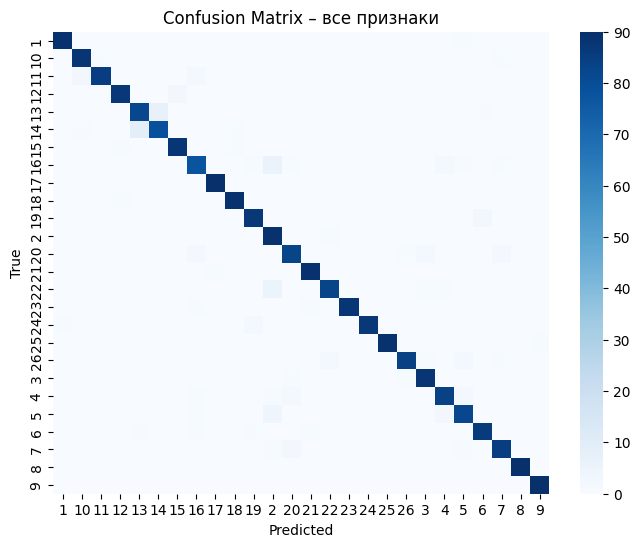

In [13]:
# 5. Базовая модель на ВСЕХ 617 признаках — ускорённая версия
clf_full = LogisticRegression(
    solver="sag",
    multi_class="multinomial",
    max_iter=1000,
    tol=1e-3,
    n_jobs=-1,
    verbose=0,
    random_state=42
)
clf_full.fit(X_train_std, y_train)
y_pred_full = clf_full.predict(X_test_std)

print("\n=== Модель на всех признаках (ускоренная) ===")
print("Accuracy:", accuracy_score(y_test, y_pred_full))
print(classification_report(y_test, y_pred_full))

# Confusion-matrix
cm_full = confusion_matrix(y_test, y_pred_full, labels=clf_full.classes_)
plt.figure(figsize=(8,6))
sns.heatmap(cm_full, annot=False, cmap="Blues", xticklabels=clf_full.classes_,
            yticklabels=clf_full.classes_)
plt.title("Confusion Matrix – все признаки")
plt.xlabel("Predicted"), plt.ylabel("True")
plt.show()


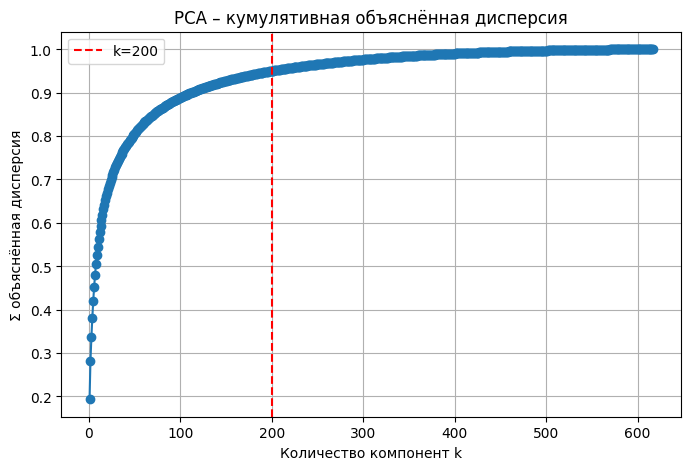

Доля дисперсии, объяснённая первыми 200 ПК: 95.03250620968003659072564914822578430175781250000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000%


/usr/local/lib/python3.11/dist-packages/sklearn/linear_model/_logistic.py:1247: FutureWarning: 'multi_class' was deprecated in version 1.5 and will be removed in 1.7. From then on, it will always use 'multinomial'. Leave it to its default value to avoid this warning.
  warnings.warn(



=== Модель на 200 главных компонентах ===
Accuracy: 0.9525641025641025
              precision    recall  f1-score   support

           1       0.98      0.99      0.98        90
          10       0.96      0.98      0.97        90
          11       0.99      0.96      0.97        90
          12       0.99      0.98      0.98        90
          13       0.88      0.89      0.88        90
          14       0.90      0.88      0.89        90
          15       0.97      0.99      0.98        90
          16       0.93      0.86      0.89        90
          17       0.99      1.00      0.99        90
          18       0.99      0.98      0.98        90
          19       0.96      0.97      0.96        90
           2       0.81      0.97      0.88        90
          20       0.90      0.91      0.91        90
          21       0.97      0.98      0.97        90
          22       0.94      0.91      0.93        90
          23       0.98      0.98      0.98        90
         

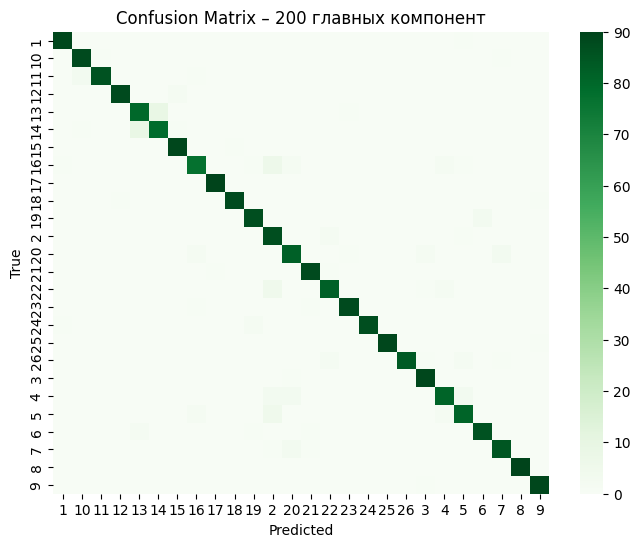

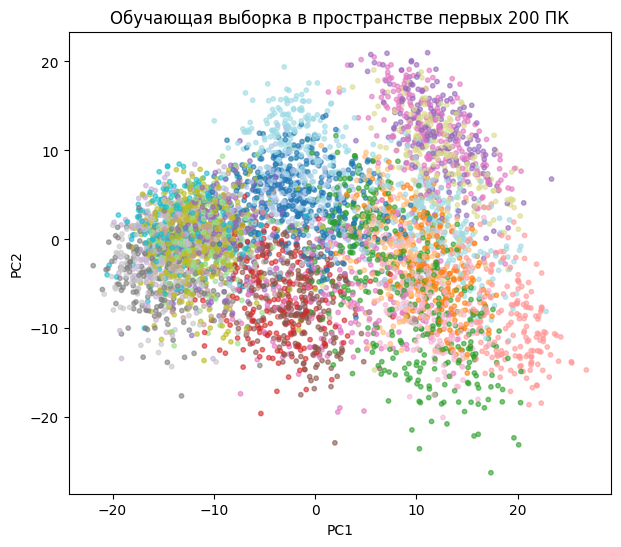

In [18]:



# 6. «Метод локтя» для PCA – вычисляем объяснённую дисперсию
pca_full = PCA().fit(X_train_std)   # обучаем PCA «со всеми» компонентами
explained = np.cumsum(pca_full.explained_variance_ratio_)

plt.figure(figsize=(8,5))
plt.plot(range(1, len(explained)+1), explained, marker="o")
plt.axvline(200, color="r", linestyle="--", label="k=200")  # « 200 - локоть»
plt.title("PCA – кумулятивная объяснённая дисперсия")
plt.xlabel("Количество компонент k"), plt.ylabel("Σ объяснённая дисперсия")
plt.grid(True), plt.legend()
plt.show()

print(f"Доля дисперсии, объяснённая первыми 200 ПК: {explained[200]:.200%}")

# 7. Сжимаем пространство до k=200 (можно легко изменить k)
pca = PCA(n_components=200, random_state=42)
X_train_pca = pca.fit_transform(X_train_std)
X_test_pca  = pca.transform(X_test_std)

# 8. Та же логистическая регрессия, но на 3 ПК
clf_pca = LogisticRegression(
    solver="lbfgs",
    multi_class="multinomial",
    max_iter=3000
)
clf_pca.fit(X_train_pca, y_train)
y_pred_pca = clf_pca.predict(X_test_pca)

print("\n=== Модель на 200 главных компонентах ===")
print("Accuracy:", accuracy_score(y_test, y_pred_pca))
print(classification_report(y_test, y_pred_pca))

# Confusion-matrix на PC-пространстве
cm_pca = confusion_matrix(y_test, y_pred_pca, labels=clf_pca.classes_)
plt.figure(figsize=(8,6))
sns.heatmap(cm_pca, annot=False, cmap="Greens", xticklabels=clf_pca.classes_,
            yticklabels=clf_pca.classes_)
plt.title("Confusion Matrix – 200 главных компонент")
plt.xlabel("Predicted"), plt.ylabel("True")
plt.show()

# 9. Визуализация (скаттер-плот первых 2 ПК)
fig = plt.figure(figsize=(7,6))
scatter = plt.scatter(X_train_pca[:,0], X_train_pca[:,1], c=pd.Categorical(y_train).codes,
                      s=10, alpha=0.6, cmap="tab20")
plt.title("Обучающая выборка в пространстве первых 200 ПК")
plt.xlabel("PC1"), plt.ylabel("PC2")
plt.show()
